In [1]:
pip install meteostat


Note: you may need to restart the kernel to use updated packages.


# Imports

In [2]:
# Standard libraries
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score

# base models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    BaggingRegressor,
    AdaBoostRegressor,
    StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# external models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Feature Engineering: open source weather data package
from meteostat import Point, Daily

In [4]:
import warnings
warnings.filterwarnings("ignore")
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress user warnings


# Loading Data

In [5]:
raw_drivers_data = pd.read_csv('data/drivers.csv')
raw_qualifying_data = pd.read_csv('data/qualifying.csv')
raw_races_data = pd.read_csv('data/races.csv')
raw_circuits_data = pd.read_csv('data/circuits.csv')
raw_constructors_data = pd.read_csv('data/constructors.csv')
test_quali_data = pd.read_csv('data/test_data/test_quali_data.csv')


# Preprocess

#### Context
We are only interested in a particular period datasets. For example 2014-2016 was one era, 2017-2021 was another era. The current era extends from 2022 all the way to 2025. Where the cars are mostly similar year on year due to minimal rule changes. Initially we will only focus on the races that occured between 2022 and 2024, to predict the qualifying laptime for the UAE Grand Prix for a particular driver. 

### **Helper Functions**

In [6]:
def get_full_quali_data(start_year=2000, end_year=2025, race_data=raw_races_data, qualifying_data=raw_qualifying_data, drivers_data=raw_drivers_data, circuits_data=raw_circuits_data, constructors_data=raw_constructors_data):
    """
    Merges and filters qualifying data for a given range of years.

    Parameters:
    start_year (int): The starting year for filtering the data. Default is 2000.
    end_year (int): The ending year for filtering the data. Default is 2025.
    race_data (pd.DataFrame): DataFrame containing race data.
    qualifying_data (pd.DataFrame): DataFrame containing qualifying data.
    drivers_data (pd.DataFrame): DataFrame containing drivers data.
    circuits_data (pd.DataFrame): DataFrame containing circuits data.
    constructors_data (pd.DataFrame): DataFrame containing constructors data.

    Returns:
    pd.DataFrame: A DataFrame containing the merged and filtered qualifying data.
    """
    race_and_circuit_data = pd.merge(race_data, circuits_data, on='circuitId', how='left')
    race_circuit_and_quali_data = pd.merge(qualifying_data, race_and_circuit_data, on='raceId', how='left')
    full_quali_data = pd.merge(race_circuit_and_quali_data, drivers_data, on='driverId', how='left')

    quali_data = full_quali_data[(full_quali_data['year'] >= start_year) & (full_quali_data['year'] <= end_year)]
    quali_data = pd.merge(quali_data, constructors_data[['constructorId', 'name']], on='constructorId', how='left')

    # print(quali_data.columns) # Uncomment to see all columns to choose from

    quali_data = quali_data[['year', 'quali_date', 'quali_time', 'name_y', 'country', 'round', 'lat', 'lng', 'alt', 'code', 'name', 'forename', 'surname', 'q1', 'q2', 'q3']]

    quali_data['year'] = quali_data['year'].astype(int)

    quali_data.rename(columns={
        'name_y': 'circuit_name',
        'lat': 'circuit_lat',
        'lng': 'circuit_lng',
        'alt': 'circuit_altitude',
        'code': 'driver_code',
        'name': 'team_name',
        'forename': 'driver_firstname',
        'surname': 'driver_lastname',
        'q1': 'qualifying_q1',
        'q2': 'qualifying_q2',
        'q3': 'qualifying_q3'
    }, inplace=True)

    return quali_data

In [7]:
def add_weather_features(quali_data):
    """
    Adds weather features (temperature, wind_speed, was_raining) to the qualifying data.

    Parameters:
        quali_data (pd.DataFrame): The input DataFrame containing qualifying data.

    Returns:
        pd.DataFrame: The updated DataFrame with weather features.
    """
    def fetch_weather_meteostat(lat, lon, date):
        location = Point(lat, lon)
        
        start = datetime.strptime(date, "%Y-%m-%d")
        end = start

        data = Daily(location, start, end)
        data = data.fetch()
        
        if not data.empty:
            temp = data.iloc[0]['tavg']  # Average temperature
            wind_speed = data.iloc[0]['wspd']  # Wind speed in kmph
            precipitation = data.iloc[0]['prcp']  # Precipitation in mm
            was_raining = 1 if precipitation > 0 else 0  # 1 if raining, 0 otherwise
            
            return {
                "temperature": temp,
                "wind_speed": wind_speed,
                "was_raining": was_raining,
            }
        else:
            return {
                "temperature": None,
                "wind_speed": None,
                "was_raining": None,
            }

    weather_features = quali_data.apply(
        lambda row: fetch_weather_meteostat(
            row["circuit_lat"],
            row["circuit_lng"],
            row["quali_date"]
        ),
        axis=1
    )

    weather_df = pd.DataFrame(weather_features.tolist())
    
    quali_data = pd.concat([quali_data, weather_df], axis=1)

    return quali_data


In [8]:
def get_classification_time(row):
    """
    Determine the classification time for a given row of qualifying data.

    This function checks the qualifying times in the order of Q3, Q2, and Q1.
    It returns the first non-null and non-zero qualifying time found. If all
    qualifying times are null or zero, it returns 0.

    Args:
        row (dict): A dictionary representing a row of qualifying data with keys
                    'qualifying_q3', 'qualifying_q2', and 'qualifying_q1'.

    Returns:
        float: The classification time from Q3, Q2, or Q1, or 0 if all are null or zero.
    """
    if row['qualifying_q3'] != '\\N' and row['qualifying_q3'] != 0:
        return row['qualifying_q3']
    elif row['qualifying_q2'] != '\\N' and row['qualifying_q2'] != 0:
        return row['qualifying_q2']
    elif row['qualifying_q1'] != '\\N' and row['qualifying_q1'] != 0:
        return row['qualifying_q1']
    else:
        return 0

def process_qualifying_order(quali_data):
    """
    Process the qualifying order data by replacing missing values and calculating classification time.

    Args:
        quali_data (pd.DataFrame): DataFrame containing qualifying data with columns 'qualifying_q1', 'qualifying_q2', 'qualifying_q3'.

    Returns:
        pd.DataFrame: Processed DataFrame with missing values replaced and a new column 'quali_classification_time' added.
    """
    quali_data[['qualifying_q1', 'qualifying_q2', 'qualifying_q3']] = quali_data[['qualifying_q1', 'qualifying_q2', 'qualifying_q3']].replace('\\N', 0)
    quali_data['quali_classification_time'] = quali_data.apply(get_classification_time, axis=1)
    return quali_data

In [9]:
def assign_quali_position(quali_data):
    """
    Assign qualifying positions based on qualifying classification time for each track in a season.

    Args:
        quali_data (pd.DataFrame): DataFrame containing qualifying data with columns 'year', 'circuit_name',
                                   and 'quali_classification_time_ms'.

    Returns:
        pd.DataFrame: DataFrame with a new column 'quali_position' added.
    """
    quali_data['quali_classification_time_ms'] = quali_data['quali_classification_time_ms'].fillna(float('inf'))
    
    quali_data['quali_position'] = (
        quali_data
        .groupby(['year', 'circuit_name'])['quali_classification_time_ms']
        .rank(method='min', ascending=True)
        .astype(int)
    )
    return quali_data


# Example usage

test_quali_data = assign_quali_position(test_quali_data)
test_quali_data.head()

test_quali_data.to_csv('data/test_data/test_quali_data.csv', index=False)


In [10]:
def convert_dtypes(quali_data):
    """
    Convert data types of specific columns in the qualifying data.

    Parameters:
        quali_data (pd.DataFrame): The input DataFrame containing qualifying data.

    Returns:
        pd.DataFrame: The updated DataFrame with converted data types.
    """
    quali_data['quali_date'] = pd.to_datetime(quali_data['quali_date'], errors='coerce') # object -> datetime
    quali_data['quali_time'] = pd.to_datetime(quali_data['quali_time'], format='%H:%M:%S', errors='coerce').dt.time # object -> time
    quali_data['round'] = quali_data['round'].astype(int) # float -> int

    time_columns = ['qualifying_q1', 'qualifying_q2', 'qualifying_q3', 'quali_classification_time'] # object -> time
    for col in time_columns:
        quali_data[col] = pd.to_datetime(quali_data[col], format='%M:%S.%f', errors='coerce').dt.time

    return quali_data

In [11]:
def time_to_milliseconds(t):
    if pd.isnull(t):
        return None
    try:
        minutes, seconds = divmod(t.minute * 60 + t.second + t.microsecond / 1e6, 60)
        return int(minutes * 60 * 1000 + seconds * 1000)
    except:
        return None

def convert_times_to_milliseconds(quali_data):
    """
    Convert time columns in the qualifying data to milliseconds.

    Parameters:
        quali_data (pd.DataFrame): The input DataFrame containing qualifying data.

    Returns:
        pd.DataFrame: The updated DataFrame with time columns converted to milliseconds.
    """
    time_columns = ['qualifying_q1', 'qualifying_q2', 'qualifying_q3', 'quali_classification_time']
    
    for col in time_columns:
        quali_data[f'{col}_ms'] = quali_data[col].apply(time_to_milliseconds)
    return quali_data

In [12]:
def ms_to_mmsssss(ms):
    """
    Convert milliseconds to MM:SS.SSS format.
    """
    minutes = int(ms // 60000)
    seconds = int((ms % 60000) // 1000)
    milliseconds = int(ms % 1000)
    return f"{minutes:02}:{seconds:02}.{milliseconds:03}"


In [13]:
def preprocess_and_split(quali_data, split_date):
    """
    Preprocess the qualifying data and split it into training and test sets based on a split date.
    Handles renaming of columns after preprocessing.

    Args:
        quali_data (pd.DataFrame): DataFrame containing qualifying data.
        split_date (str): The date used to split the data into training and test sets in the format "YYYY-MM-DD".

    Returns:
        X_train, y_train, X_test, y_test: Preprocessed and split features and targets.
    """
    round_order = np.sort(quali_data["round"].unique())
    quali_pos_order = np.sort(quali_data["quali_position"].unique())
    years_order = np.sort(quali_data["year"].unique())

    categorical_feats = ["circuit_name", "team_name", "driver_code"]
    numeric_feats = ["circuit_altitude", "temperature", "wind_speed"]
    ordinal_feats = ["round", "quali_position", "year"]
    drop_feats = [
        "quali_time", "country", "circuit_lat", "circuit_lng",
        "driver_firstname", "driver_lastname", "qualifying_q1", "qualifying_q2",
        "qualifying_q3", "quali_classification_time", "qualifying_q1_ms",
        "qualifying_q2_ms", "qualifying_q3_ms"
    ]
    target = ["quali_classification_time_ms"]

    quali_data["quali_date_numeric"] = (pd.to_datetime(quali_data["quali_date"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta(days=1)
    numeric_feats.append("quali_date_numeric")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler()
    )
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    ordinal_transformer = OrdinalEncoder(categories=[list(round_order), list(quali_pos_order), list(years_order)], dtype=int)

    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (ordinal_transformer, ordinal_feats),
        ("drop", drop_feats)
    )

    train_df = quali_data[quali_data["quali_date"] < split_date]
    test_df = quali_data[quali_data["quali_date"] >= split_date]

    X_train = train_df.drop(columns=target)
    y_train = train_df[target]
    X_test = test_df.drop(columns=target)
    y_test = test_df[target]

    y_train = np.where(np.isinf(y_train), 200000.0, y_train)  # Replace inf with 200000.0
    y_test = np.where(np.isinf(y_test), 200000.0, y_test)  # Replace inf with 200000.0

    y_train = y_train.astype(np.float64)
    y_test = y_test.astype(np.float64)

    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    onehot_encoded_cols = (
        list(preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(categorical_feats))
        if "onehotencoder" in preprocessor.named_transformers_ else []
    )
    column_names = (
        onehot_encoded_cols +
        numeric_feats +
        ordinal_feats
    )

    if X_train_transformed.shape[1] != len(column_names):
        raise ValueError(
            f"Shape mismatch: Transformed data has {X_train_transformed.shape[1]} columns, "
            f"but {len(column_names)} column names were provided."
        )

    X_train = pd.DataFrame.sparse.from_spmatrix(
        X_train_transformed, 
        columns=column_names, 
        index=train_df.index
    )
    X_test = pd.DataFrame.sparse.from_spmatrix(
        X_test_transformed, 
        columns=column_names, 
        index=test_df.index
    )

    # dropping 'quali_date' 
    if "quali_date" in X_train.columns:
        X_train.drop(columns="quali_date", inplace=True)
    if "quali_date" in X_test.columns:
        X_test.drop(columns="quali_date", inplace=True)

    return X_train, y_train, X_test, y_test


In [14]:
def mean_std_cross_val_scores(estimator, X, y, cv=20, return_train_score=False, scoring=""):
    """
    Calculate mean and standard deviation of cross-validation scores for an estimator.

    Args:
        estimator: The estimator to evaluate.
        X: Feature matrix.
        y: Target vector.
        cv: Number of cross-validation folds (default is 5).
        return_train_score: If True, include train scores (default is False).
        scoring: The scoring metric to use (default is "neg_mean_squared_error").

    Returns:
        dict: A dictionary containing mean and std of test (and optionally train) scores.
    """
    # Cross-validation for test scores
    test_scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    result = {
        "test_score_mean": np.mean(test_scores),
        "test_score_std": np.std(test_scores),
    }

    # Optionally include train scores
    if return_train_score:
        train_scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
        result["train_score_mean"] = np.mean(train_scores)
        result["train_score_std"] = np.std(train_scores)

    return result


```markdown

```

#### Manipulating Data

first we need to slice the data to only include the relevant years from 2022-2024

In [15]:
quali_2022_to_2025 = get_full_quali_data(2022, 2025)    # Ground Effect Era
quali_2017_to_2021 = get_full_quali_data(2017, 2021)    # Wider, Faster Cars Era
quali_2014_to_2016 = get_full_quali_data(2014, 2016)    # Hybrid Power Units Era
quali_2010_to_2013 = get_full_quali_data(2010, 2013)    # V8 Engines Era, Double Diffuser
quali_2006_to_2009 = get_full_quali_data(2005, 2009)    # V8 Engines Era, Single Diffuser
quali_2000_to_2005 = get_full_quali_data(2000, 2004)    # V10 Engines Era

quali = get_full_quali_data() # Default is 2000 to 2025 to capture modern F1 cars

Just Abu Dhabhi Data

In [16]:
abu_dhabi_data = raw_races_data[raw_races_data['name'] == 'Abu Dhabi Grand Prix'] 

#### Feature Engineering

In [17]:
quali_2022_to_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1119 non-null   int64  
 1   quali_date        1119 non-null   object 
 2   quali_time        1119 non-null   object 
 3   circuit_name      1119 non-null   object 
 4   country           1119 non-null   object 
 5   round             1119 non-null   float64
 6   circuit_lat       1119 non-null   float64
 7   circuit_lng       1119 non-null   float64
 8   circuit_altitude  1119 non-null   float64
 9   driver_code       1119 non-null   object 
 10  team_name         1119 non-null   object 
 11  driver_firstname  1119 non-null   object 
 12  driver_lastname   1119 non-null   object 
 13  qualifying_q1     1119 non-null   object 
 14  qualifying_q2     1106 non-null   object 
 15  qualifying_q3     1092 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory

In [18]:
quali_2022_to_2025.shape

(1119, 16)

In [19]:
quali_2022_to_2025 = add_weather_features(quali_2022_to_2025)

In [20]:
quali_2022_to_2025 = process_qualifying_order(quali_2022_to_2025)

In [21]:
quali_2022_to_2025.head()

,year,quali_date,quali_time,circuit_name,country,round,circuit_lat,circuit_lng,circuit_altitude,driver_code,team_name,driver_firstname,driver_lastname,qualifying_q1,qualifying_q2,qualifying_q3,temperature,wind_speed,was_raining,quali_classification_time
0,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1.0,26.0325,50.5106,7.0,LEC,Ferrari,Charles,Leclerc,1:31.471,1:30.932,1:30.558,18.8,25.9,0,1:30.558
1,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1.0,26.0325,50.5106,7.0,VER,Red Bull,Max,Verstappen,1:31.785,1:30.757,1:30.681,18.8,25.9,0,1:30.681
2,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1.0,26.0325,50.5106,7.0,SAI,Ferrari,Carlos,Sainz,1:31.567,1:30.787,1:30.687,18.8,25.9,0,1:30.687
3,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1.0,26.0325,50.5106,7.0,PER,Red Bull,Sergio,Pérez,1:32.311,1:31.008,1:30.921,18.8,25.9,0,1:30.921
4,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1.0,26.0325,50.5106,7.0,HAM,Mercedes,Lewis,Hamilton,1:32.285,1:31.048,1:31.238,18.8,25.9,0,1:31.238


In [22]:
quali_2022_to_2025.tail()

,year,quali_date,quali_time,circuit_name,country,round,circuit_lat,circuit_lng,circuit_altitude,driver_code,team_name,driver_firstname,driver_lastname,qualifying_q1,qualifying_q2,qualifying_q3,temperature,wind_speed,was_raining,quali_classification_time
1114,2024,2024-07-06,14:00:00,Silverstone Circuit,UK,12.0,52.0786,-1.01694,153.0,BOT,Sauber,Valtteri,Bottas,1:32.431,0,0,12.7,19.4,1,1:32.431
1115,2024,2024-07-06,14:00:00,Silverstone Circuit,UK,12.0,52.0786,-1.01694,153.0,MAG,Haas F1 Team,Kevin,Magnussen,1:32.905,0,0,12.7,19.4,1,1:32.905
1116,2024,2024-07-06,14:00:00,Silverstone Circuit,UK,12.0,52.0786,-1.01694,153.0,OCO,Alpine F1 Team,Esteban,Ocon,1:34.557,0,0,12.7,19.4,1,1:34.557
1117,2024,2024-07-06,14:00:00,Silverstone Circuit,UK,12.0,52.0786,-1.01694,153.0,PER,Red Bull,Sergio,Pérez,1:38.348,0,0,12.7,19.4,1,1:38.348
1118,2024,2024-07-06,14:00:00,Silverstone Circuit,UK,12.0,52.0786,-1.01694,153.0,GAS,Alpine F1 Team,Pierre,Gasly,1:39.804,0,0,12.7,19.4,1,1:39.804


lets now look the info for dtypes and make the necessary changes

In [23]:
quali_2022_to_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       1119 non-null   int64  
 1   quali_date                 1119 non-null   object 
 2   quali_time                 1119 non-null   object 
 3   circuit_name               1119 non-null   object 
 4   country                    1119 non-null   object 
 5   round                      1119 non-null   float64
 6   circuit_lat                1119 non-null   float64
 7   circuit_lng                1119 non-null   float64
 8   circuit_altitude           1119 non-null   float64
 9   driver_code                1119 non-null   object 
 10  team_name                  1119 non-null   object 
 11  driver_firstname           1119 non-null   object 
 12  driver_lastname            1119 non-null   object 
 13  qualifying_q1              1119 non-null   objec

In [24]:
quali_2022_to_2025 = convert_dtypes(quali_2022_to_2025)
quali_2022_to_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   year                       1119 non-null   int64         
 1   quali_date                 1119 non-null   datetime64[ns]
 2   quali_time                 1119 non-null   object        
 3   circuit_name               1119 non-null   object        
 4   country                    1119 non-null   object        
 5   round                      1119 non-null   int64         
 6   circuit_lat                1119 non-null   float64       
 7   circuit_lng                1119 non-null   float64       
 8   circuit_altitude           1119 non-null   float64       
 9   driver_code                1119 non-null   object        
 10  team_name                  1119 non-null   object        
 11  driver_firstname           1119 non-null   object        
 12  driver

In [25]:
quali_2022_to_2025 = convert_times_to_milliseconds(quali_2022_to_2025)

In [26]:
quali_2022_to_2025 = assign_quali_position(quali_2022_to_2025)

In [27]:
quali_2022_to_2025[['year', 'circuit_name', 'driver_code', 'quali_classification_time_ms', 'quali_position']].to_csv('data/test_data/test_order_data.csv', index=False)

### EDA + Visualizations 

first lets look at tracks


Number of Unique Tracks: 25


<Axes: title={'center': 'Total Drivers Participated in Qualifying from 2022-2025 per Track'}, xlabel='circuit_name'>

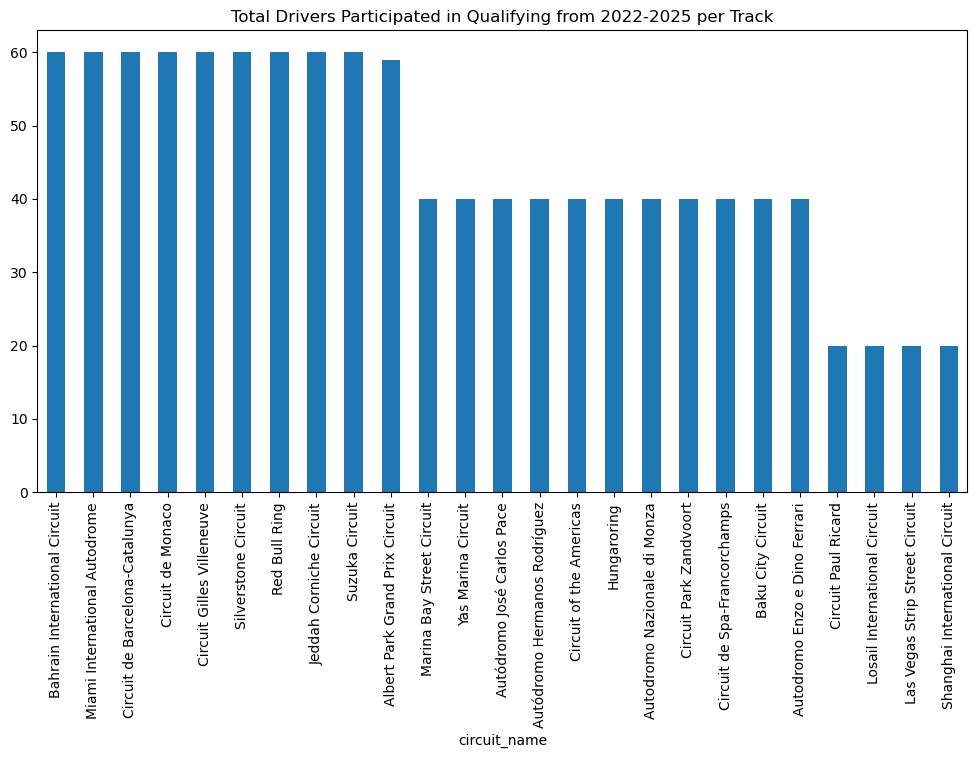

In [28]:
print(f"Number of Unique Tracks: {quali_2022_to_2025['circuit_name'].nunique()}")
quali_2022_to_2025['circuit_name'].value_counts().plot(kind='bar', figsize=(12, 6), title='Total Drivers Participated in Qualifying from 2022-2025 per Track')

**Note**: the 2024 data only goes as far as silverstone. France was removed from the calendar after 2022. Qatar was officially back in 2023 (i think), Las vegas was introduced in 2023. Shanghai returned in 2024.

```markdown

```

Number of Unique Driver Codes: 26


<Axes: title={'center': 'Number of Times Each Driver Code Showed Up to Quali from 2022-2024'}, xlabel='driver_code'>

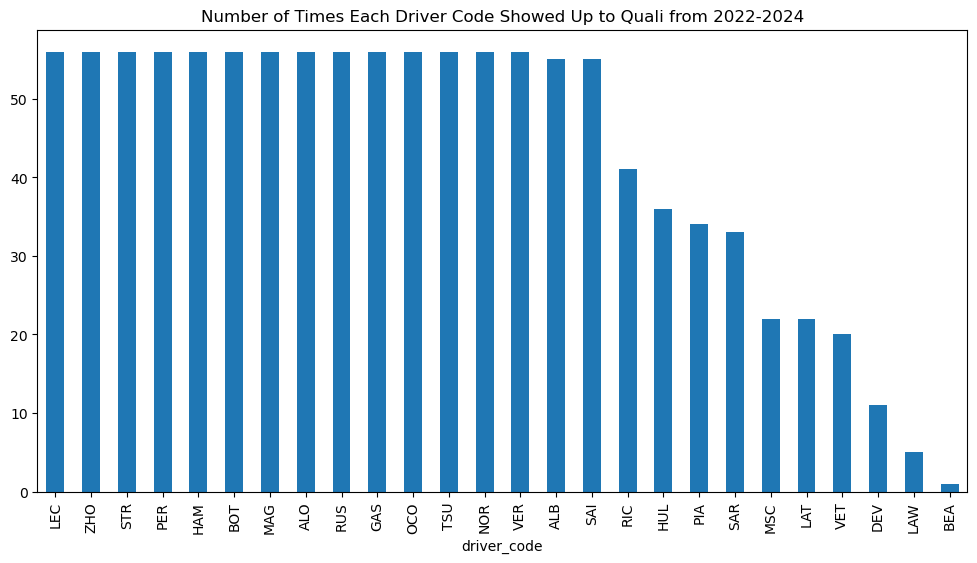

In [29]:
print(f"Number of Unique Driver Codes: {quali_2022_to_2025['driver_code'].nunique()}")
quali_2022_to_2025['driver_code'].value_counts().plot(kind='bar', figsize=(12, 6), title='Number of Times Each Driver Code Showed Up to Quali from 2022-2024')

**Note**: Bearmen just drove one race (maybe another?). Liam Lawson drove only the last few races of 2023. Vettel retired after 2022. Nick Devries was removed from alpha tauri midway in 2023 to be replaced by Riccardo who then crashed and got replaced by Lawson, then recovered and joined back in 2023. Mick Schumacher was removed post 2022. Piastri joined 2023 (data only goes as far as Silverstone 2024). Hulkenberg returned in 2023. Rest of the data looks OK

```markdown

```

In [30]:
quali_2022_to_2025.head()

,year,quali_date,quali_time,circuit_name,country,round,circuit_lat,circuit_lng,circuit_altitude,driver_code,...,qualifying_q3,temperature,wind_speed,was_raining,quali_classification_time,qualifying_q1_ms,qualifying_q2_ms,qualifying_q3_ms,quali_classification_time_ms,quali_position
0,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1,26.0325,50.5106,7.0,LEC,...,00:01:30.558000,18.8,25.9,0,00:01:30.558000,91471.0,90932.0,90558.0,90558.0,1
1,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1,26.0325,50.5106,7.0,VER,...,00:01:30.681000,18.8,25.9,0,00:01:30.681000,91785.0,90757.0,90681.0,90681.0,2
2,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1,26.0325,50.5106,7.0,SAI,...,00:01:30.687000,18.8,25.9,0,00:01:30.687000,91567.0,90787.0,90687.0,90687.0,3
3,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1,26.0325,50.5106,7.0,PER,...,00:01:30.921000,18.8,25.9,0,00:01:30.921000,92311.0,91008.0,90921.0,90921.0,4
4,2022,2022-03-19,15:00:00,Bahrain International Circuit,Bahrain,1,26.0325,50.5106,7.0,HAM,...,00:01:31.238000,18.8,25.9,0,00:01:31.238000,92285.0,91048.0,91238.0,91238.0,5


now, lets look at the preprocessed data saved to a csv

In [31]:
quali_2022_to_2025.to_csv('data/test_data/test_data.csv', index=False)
quali_2022_to_2025.to_csv('data/viz/quali_2022_to_2025_data.csv', index=False)

In [32]:
quali_2022_to_2025.columns

Index(['year', 'quali_date', 'quali_time', 'circuit_name', 'country', 'round',
       'circuit_lat', 'circuit_lng', 'circuit_altitude', 'driver_code',
       'team_name', 'driver_firstname', 'driver_lastname', 'qualifying_q1',
       'qualifying_q2', 'qualifying_q3', 'temperature', 'wind_speed',
       'was_raining', 'quali_classification_time', 'qualifying_q1_ms',
       'qualifying_q2_ms', 'qualifying_q3_ms', 'quali_classification_time_ms',
       'quali_position'],
      dtype='object')

In [33]:
quali_2022_to_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   year                          1119 non-null   int64         
 1   quali_date                    1119 non-null   datetime64[ns]
 2   quali_time                    1119 non-null   object        
 3   circuit_name                  1119 non-null   object        
 4   country                       1119 non-null   object        
 5   round                         1119 non-null   int64         
 6   circuit_lat                   1119 non-null   float64       
 7   circuit_lng                   1119 non-null   float64       
 8   circuit_altitude              1119 non-null   float64       
 9   driver_code                   1119 non-null   object        
 10  team_name                     1119 non-null   object        
 11  driver_firstname              

# Preprocessing

In [34]:
X_train, y_train, X_test, y_test = preprocess_and_split(quali_2022_to_2025, split_date="2024-06-08")

In [35]:
# print("X_train memory usage:", X_train.memory_usage(deep=True).sum(), "bytes")
# print("X_test memory usage:", X_test.memory_usage(deep=True).sum(), "bytes")
# print("y_train memory usage:", y_train.memory_usage(deep=True).sum(), "bytes")
# print("y_test memory usage:", y_test.memory_usage(deep=True).sum(), "bytes")
# print("total memory usage:", X_train.memory_usage(deep=True).sum() + X_test.memory_usage(deep=True).sum() + y_train.memory_usage(deep=True).sum() + y_test.memory_usage(deep=True).sum(), "bytes")

In [36]:
y_train.mean()

90260.22040423485

In [37]:
X_train.to_csv('data/X_train.csv', index=False)

In [38]:
X_test.to_csv('data/X_test.csv', index=False)

# ML Models

#### Baseline

In [39]:
results_dict = {}
dummy = DummyRegressor()
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, scoring="neg_mean_absolute_error", return_train_score=True
)

pd.DataFrame(results_dict).T

,test_score_mean,test_score_std,train_score_mean,train_score_std
dummy,-13241.674783,7236.648416,-13241.674783,7236.648416


In [40]:
results_dict = {}

models = {
    "baseline": DummyRegressor(),
    "linear_regression": LinearRegression(),
    "ridge_regression": Ridge(),
    "lasso_regression": Lasso(),
    "svr": SVR(),
    "random_forest": RandomForestRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "xgboost": xgb.XGBRegressor(),
    "lightgbm": lgb.LGBMRegressor(verbosity=-1),
    "elastic_net": ElasticNet(),
    "decision_tree": DecisionTreeRegressor(),
    "extra_trees": ExtraTreesRegressor(),
    "catboost": cb.CatBoostRegressor(verbose=0),
    "knn": KNeighborsRegressor(),
    "huber": HuberRegressor(),
    "bagging": BaggingRegressor(),
    "ada_boost": AdaBoostRegressor()
    # "stacking": StackingRegressor(
    #     estimators=[
    #         ('ridge', Ridge()), 
    #         ('svr', SVR()),
    #         ('random_forest', RandomForestRegressor())
    #     ]
    # )
}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    
    for model_name, model in models.items():
        # Convert to dense for models that require it
        if model_name in [
            "svr", "linear_regression", "ridge_regression", 
            "lasso_regression", "elastic_net", "huber", "knn"
        ]:
            X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train.values
            results_dict[model_name] = mean_std_cross_val_scores(
                model, X_train_dense, y_train, scoring="neg_mean_absolute_error", return_train_score=True
            )
        else:
            # Use sparse matrix for models that support it
            results_dict[model_name] = mean_std_cross_val_scores(
                model, X_train, y_train, scoring="neg_mean_absolute_error", return_train_score=True
            )
        print(f"Completed: {model_name}")

results_df = pd.DataFrame(results_dict).T


Completed: baseline
Completed: linear_regression
Completed: ridge_regression
Completed: lasso_regression
Completed: svr
Completed: random_forest
Completed: gradient_boosting
Completed: xgboost
Completed: lightgbm
Completed: elastic_net
Completed: decision_tree
Completed: extra_trees
Completed: catboost
Completed: knn
Completed: huber
Completed: bagging
Completed: ada_boost


In [41]:
results_df

,test_score_mean,test_score_std,train_score_mean,train_score_std
baseline,-1.324167e+04,7.236648e+03,-1.324167e+04,7.236648e+03
linear_regression,-1.018634e+15,2.757741e+15,-1.018634e+15,2.757741e+15
ridge_regression,-1.376343e+04,8.667592e+03,-1.376343e+04,8.667592e+03
lasso_regression,-1.463100e+04,8.905280e+03,-1.463100e+04,8.905280e+03
svr,-1.294574e+04,7.131615e+03,-1.294574e+04,7.131615e+03
random_forest,-1.199802e+04,1.115942e+04,-1.214925e+04,1.102645e+04
gradient_boosting,-1.131244e+04,8.837640e+03,-1.137129e+04,8.888335e+03
xgboost,-1.149027e+04,1.056464e+04,-1.149027e+04,1.056464e+04
lightgbm,-1.270884e+04,1.160323e+04,-1.270884e+04,1.160323e+04
elastic_net,-1.357845e+04,7.272006e+03,-1.357845e+04,7.272006e+03


#### Comparing Model Accuracy for Max Verstappen's 2024 Austria Pole Laptime (Training Period: Bahrain 2023 - Silverstone 2024)

In [42]:
# from sklearn.preprocessing import MinMaxScaler

# point_index = 40
# X_point = X_test.iloc[point_index].to_numpy().reshape(1, -1)  
# y_point_actual = y_test[point_index]  

# predictions = {}
# probabilities = {}
# scaler = MinMaxScaler()

# for model_name, model in models.items():
#     if model_name in ["svr", "linear_regression", "ridge_regression", "lasso_regression"]:
#         model.fit(X_train.to_numpy(), y_train)
#         predictions[model_name] = model.predict(X_point)[0]
#         probabilities[model_name] = scaler.fit_transform(model.predict(X_test.values).reshape(-1, 1))[point_index][0]
#     else:
#         model.fit(X_train, y_train)
#         predictions[model_name] = model.predict(X_point)[0]
#         probabilities[model_name] = scaler.fit_transform(model.predict(X_test).reshape(-1, 1))[point_index][0]

# predictions["actual"] = y_point_actual
# probabilities["actual"] = 1.0  # Actual value has a probability of 1

# predictions_df = pd.DataFrame(predictions, index=["prediction"]).T


In [43]:
# predictions_df['predicted_laptime'] = predictions_df['prediction'].apply(ms_to_mmsssss)
# predictions_df['delta'] = (
#     (predictions_df['prediction'] - predictions_df.loc['actual', 'prediction']).abs() / 1000
# ).round(3)

# predictions_df = predictions_df.sort_values(by='delta', ascending=True)
# predictions_df

hmmmmm...

<img src="pics/sad.png" alt="Image Description" width="750" height="500">

Thats not too bad, not too great either. I have mixed feelings about these results. Frankly I was expecting the ensemble models to perform a little better than this. Not all hope is lost though, there are a number of ways to improve the performance of these models to get an ever lower delta for prediction.

#### Prediction for Abu Dhabi

In [44]:
abu_dhabi_2024_quali = pd.read_csv('data/abu_dhabi.csv')

In [45]:
# from sklearn.preprocessing import MinMaxScaler

# point_index = 0
# X_point = abu_dhabi_2024_quali.iloc[point_index].to_numpy().reshape(1, -1)  
# y_point_actual = y_test[point_index]  

# predictions = {}
# probabilities = {}
# scaler = MinMaxScaler()

# for model_name, model in models.items():
#     if model_name in ["svr", "linear_regression", "ridge_regression", "lasso_regression"]:
#         model.fit(X_train.to_numpy(), y_train)
#         predictions[model_name] = model.predict(X_point)[0]
#         probabilities[model_name] = scaler.fit_transform(model.predict(X_test.values).reshape(-1, 1))[point_index][0]
#     else:
#         model.fit(X_train, y_train)
#         predictions[model_name] = model.predict(X_point)[0]
#         probabilities[model_name] = scaler.fit_transform(model.predict(X_test).reshape(-1, 1))[point_index][0]


# predictions_df = pd.DataFrame(predictions, index=["prediction"]).T
# predictions_df['predicted_laptime'] = predictions_df['prediction'].apply(ms_to_mmsssss)
# predictions_df = predictions_df.sort_values(by='prediction', ascending=True)
# predictions_df

In [46]:
driver_map = {
    0 : 'VER',
    1 : 'PER',
    3 : 'LEC',
    4 : 'SAI',
    5 : 'HAM',
    6 : 'RUS',
    7 : 'NOR',
    8 : 'PIA',
    9 : 'OCO',
    10 : 'GAS',
    11 : 'VET',
    12 : 'RIC',
    13 : 'ALO',
    14 : 'TSU',
    15 : 'MSC',
    16 : 'STR',
    17 : 'ZHO',
    18 : 'LAT',
    19 : 'MAG',
    20 : 'GAS',
}

In [49]:
from sklearn.preprocessing import MinMaxScaler

predicted_laptime_abu_dhabi_2024 = {}

for key, value in driver_map.items():
    print(f'PREDICTION  for {value}')
    point_index = key
    X_point = abu_dhabi_2024_quali.iloc[point_index].to_numpy().reshape(1, -1)  
    
    predictions = {}
    probabilities = {}
    scaler = MinMaxScaler()

    for model_name, model in models.items():
        if model_name in ["svr", "linear_regression", "ridge_regression", "lasso_regression"]:
            model.fit(X_train.to_numpy(), y_train)
            predictions[model_name] = model.predict(X_point)[0]
            probabilities[model_name] = scaler.fit_transform(model.predict(X_test.values).reshape(-1, 1))[point_index][0]
        else:
            model.fit(X_train, y_train)
            predictions[model_name] = model.predict(X_point)[0]
            probabilities[model_name] = scaler.fit_transform(model.predict(X_test).reshape(-1, 1))[point_index][0]


    predictions_df = pd.DataFrame(predictions, index=["prediction"]).T
    predictions_df['predicted_laptime'] = predictions_df['prediction'].apply(ms_to_mmsssss)
    predictions_df = predictions_df.sort_values(by='prediction', ascending=True)
    print(predictions_df)

    predicted_laptime = predictions_df['predicted_laptime'].iloc[0]
    predicted_laptime_abu_dhabi_2024[key] = predicted_laptime
    print('')
    

PREDICTION  for VER
                      prediction predicted_laptime
knn                 83737.400000         01:23.737
decision_tree       83824.000000         01:23.824
bagging             83883.200000         01:23.883
extra_trees         83888.710000         01:23.888
random_forest       84036.800000         01:24.036
lightgbm            84036.957147         01:24.036
xgboost             84280.000000         01:24.280
catboost            84583.351289         01:24.583
ada_boost           85116.771588         01:25.116
gradient_boosting   85127.594260         01:25.127
svr                 87796.224305         01:27.796
baseline            90260.220404         01:30.260
elastic_net         90881.332763         01:30.881
ridge_regression   123834.878770         02:03.834
lasso_regression   136440.182804         02:16.440
huber              141968.090445         02:21.968
linear_regression  207992.000000         03:27.992

PREDICTION  for PER
                      prediction predicte

In [50]:
for key, value in predicted_laptime_abu_dhabi_2024.items():
    print(f'{driver_map[key]}: {value}')

VER: 01:23.737
PER: 01:23.737
LEC: 01:23.785
SAI: 01:23.737
HAM: 01:23.632
RUS: 01:22.960
NOR: 01:22.821
PIA: 01:23.791
OCO: 01:23.687
GAS: 01:22.821
VET: 01:23.439
RIC: 01:23.740
ALO: 01:23.287
TSU: 01:23.791
MSC: 01:22.821
STR: 01:23.791
ZHO: 01:23.681
LAT: 01:23.785
MAG: 01:23.759
GAS: 01:16.896
